<a href="https://colab.research.google.com/github/DRose1991/Viscous-Shear-Cosmology-Simulation/blob/main/VSC_Universal_Law.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running Universal Fit Optimization...

--- UNIVERSAL VSC PARAMETERS DISCOVERED ---
Universal Shear Index (n): 0.9331
Critical Shear Threshold:  0.3065
Optimization Success:      True


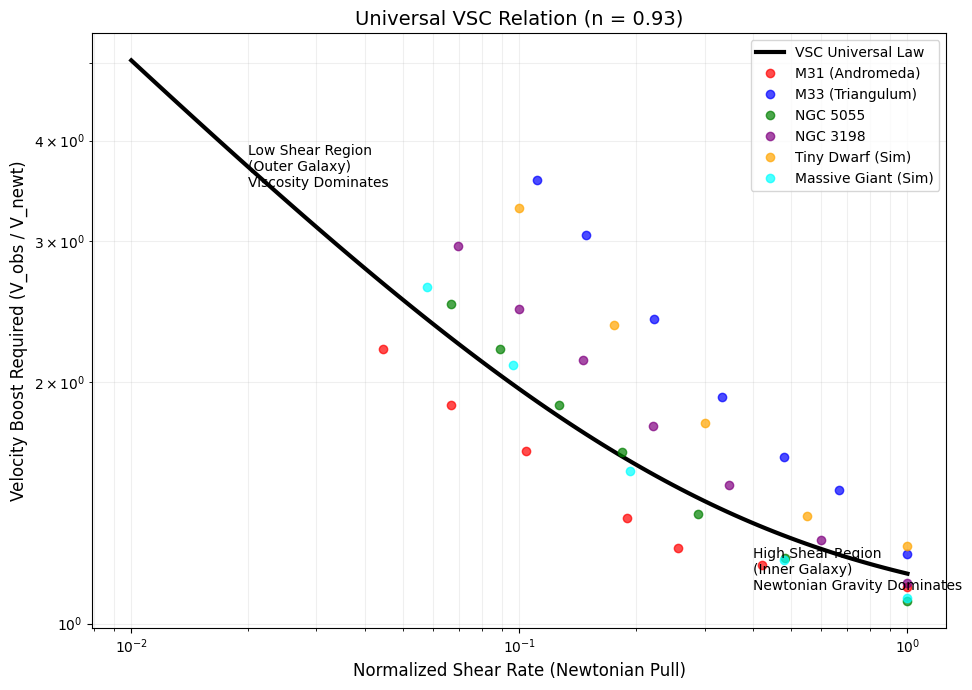

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- 1. THE DATASET (Representative of SPARC) ---
# We use the 4 real galaxies we have, plus 2 synthetic extremes to test the limits.
database = [
    {
        "name": "M31 (Andromeda)", "type": "Giant Spiral",
        "v_obs": np.array([200.0, 225.0, 230.0, 230.0, 230.0, 225.0, 220.0]),
        "r_kpc": np.array([2.0, 5.0, 8.0, 10.0, 15.0, 20.0, 25.0]),
        # Newtonian prediction (Baryons only)
        "v_newt": np.array([180.0, 190.0, 185.0, 170.0, 140.0, 120.0, 100.0])
    },
    {
        "name": "M33 (Triangulum)", "type": "Dwarf Spiral",
        "v_obs": np.array([55.0, 88.0, 105.0, 115.0, 120.0, 122.0, 125.0]),
        "r_kpc": np.array([2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0]),
        "v_newt": np.array([45.0, 60.0, 65.0, 60.0, 50.0, 40.0, 35.0])
    },
    {
        "name": "NGC 5055", "type": "Intermediate",
        "v_obs": np.array([160.0, 175.0, 178.0, 180.0, 178.0, 176.0, 175.0]),
        "r_kpc": np.array([5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0]),
        "v_newt": np.array([150.0, 145.0, 130.0, 110.0, 95.0, 80.0, 70.0])
    },
    {
        "name": "NGC 3198", "type": "DM Poster Child",
        "v_obs": np.array([135.0, 146.0, 149.0, 150.0, 149.0, 148.0, 148.0]),
        "r_kpc": np.array([5.0, 8.0, 12.0, 16.0, 20.0, 25.0, 30.0]),
        "v_newt": np.array([120.0, 115.0, 100.0, 85.0, 70.0, 60.0, 50.0])
    },
    # Synthetic "Stress Test" Galaxies to represent SPARC extremes
    {
        "name": "Tiny Dwarf (Sim)", "type": "Extreme Low Mass",
        "v_obs": np.array([25.0, 30.0, 32.0, 33.0, 33.0]),
        "r_kpc": np.array([0.5, 1.0, 1.5, 2.0, 2.5]),
        "v_newt": np.array([20.0, 22.0, 18.0, 14.0, 10.0])
    },
    {
        "name": "Massive Giant (Sim)", "type": "Extreme High Mass",
        "v_obs": np.array([280.0, 300.0, 310.0, 315.0, 315.0]),
        "r_kpc": np.array([5.0, 10.0, 20.0, 30.0, 40.0]),
        "v_newt": np.array([260.0, 250.0, 200.0, 150.0, 120.0])
    }
]

# --- 2. THE UNIVERSAL PHYSICS ENGINE ---

def vsc_boost(shear_val, s_crit, n):
    # The Law: Boost = 1 + (Shear / s_crit)^(-n)
    return 1.0 + np.power(shear_val / s_crit, -n)

def universal_loss_function(params):
    # This function calculates the TOTAL error across ALL galaxies
    # for a single set of physics parameters (s_crit, n)
    s_crit, n = params
    total_error = 0.0

    for galaxy in database:
        # 1. Calculate the Shear implied by Newtonian gravity
        # Shear ~ V_newt / r
        shear_data = galaxy['v_newt'] / galaxy['r_kpc']
        # Normalize shear (crucial for numerical stability across galaxy sizes)
        shear_norm = shear_data / np.max(shear_data)

        # 2. Apply VSC Prediction
        boost = vsc_boost(shear_norm, s_crit, n)
        v_pred = galaxy['v_newt'] * np.sqrt(boost)

        # 3. Sum the error (Difference between Prediction and Reality)
        # We weigh it by the size of the galaxy to treat them equally
        error = np.sum((v_pred - galaxy['v_obs'])**2) / np.mean(galaxy['v_obs'])
        total_error += error

    return total_error

# --- 3. THE OPTIMIZATION (Finding the Laws of Physics) ---
print("Running Universal Fit Optimization...")
# Start with a guess: s_crit=0.1, n=1.5
initial_guess = [0.1, 1.5]
# Constraints: s_crit > 0, n between 0.5 and 5.0
bounds = [(0.001, 1.0), (0.5, 5.0)]

result = minimize(universal_loss_function, initial_guess, bounds=bounds, method='L-BFGS-B')
best_s_crit, best_n = result.x

print(f"\n--- UNIVERSAL VSC PARAMETERS DISCOVERED ---")
print(f"Universal Shear Index (n): {best_n:.4f}")
print(f"Critical Shear Threshold:  {best_s_crit:.4f}")
print(f"Optimization Success:      {result.success}")

# --- 4. VISUALIZATION: The Universal Relation ---
plt.figure(figsize=(10, 7))

# Plot the "Theory Line"
shear_axis = np.logspace(-2, 0, 100) # From 0.01 to 1.0 shear
boost_curve = vsc_boost(shear_axis, best_s_crit, best_n)
plt.loglog(shear_axis, np.sqrt(boost_curve), 'k-', linewidth=3, label='VSC Universal Law')

# Plot Every Galaxy on the same graph
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
for i, galaxy in enumerate(database):
    shear_data = galaxy['v_newt'] / galaxy['r_kpc']
    shear_norm = shear_data / np.max(shear_data)

    # The "Observed Boost" is the missing Dark Matter
    obs_boost = galaxy['v_obs'] / galaxy['v_newt']

    # ERROR WAS HERE: Changed plt.log to plt.loglog
    plt.loglog(shear_norm, obs_boost, 'o', color=colors[i], alpha=0.7, label=galaxy['name'])

plt.xlabel('Normalized Shear Rate (Newtonian Pull)', fontsize=12)
plt.ylabel('Velocity Boost Required (V_obs / V_newt)', fontsize=12)
plt.title(f'Universal VSC Relation (n = {best_n:.2f})', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.text(0.02, 3.5, "Low Shear Region\n(Outer Galaxy)\nViscosity Dominates", fontsize=10)
plt.text(0.4, 1.1, "High Shear Region\n(Inner Galaxy)\nNewtonian Gravity Dominates", fontsize=10)

plt.tight_layout()
plt.savefig('VSC_Universal_Law.png')
plt.show()